### Time Series (차원size 및 view 처리 이해)
> Seqence 7개 묶음으로 긴 날짜를 Window 이동하면서 데이터 파악

> 다중(Window 이동 O) many-to-*One [ 최종출력은 마지막 만 ]

> 특징 factor는 5개 (ex.시, 고, 저, 종, 거래량 )

> Window Dataset 로직 → 함수로

> 다중 네트워크(FC추가) → Class로 구현

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Random seed to make results deterministic and reproducible 
torch.manual_seed(0)

In [2]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

### Window Dataset 함수

In [3]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  #    * many-to-one 이기 때문에 마지막 1개 값만!!
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

#### 데이터 로드

In [4]:
# load
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order
print(xy.shape)
print(xy[:3])

(732, 5)
[[  568.00257    568.00257    552.922516 13100.         558.462551]
 [  561.202549   566.43259    558.672539 41200.         559.992565]
 [  566.892592   567.002574   556.932537 10800.         556.972503]]


#### many-to-many와 준비 데이터 셋 부터 다름 : Y가 1이 됨 

#### 데이터 작업
> seq_length는 데이터 작업 시에만 필요(네트워크 모델쪽과 관련X)

In [5]:
torch.cuda.is_available()

/home/hubuc/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [31]:
seq_length = 7  

# Split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # train이 train_size만큼 진행 X 
print('단순 Split한 Train_size :', train_size)                                                     

# Scaling
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# Window Dataset 처리
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# Tensor 변환
trainX_tensor = torch.FloatTensor(trainX)  #            512 - 7 = 505 만큼의 window 묶음(7단위)이 train_X로 준비 될 것
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)    # (732-505) -7 = 220 만큼의 window 묶음(7단위)이 test_X로 준비 될 것
testY_tensor = torch.FloatTensor(testY)

단순 Split한 Train_size : 512


In [36]:
print(trainX_tensor.shape)
print(trainY_tensor.shape)
print(testX_tensor.shape)
print(testY_tensor.shape)

torch.Size([505, 7, 5])
torch.Size([505, 1])
torch.Size([220, 7, 5])
torch.Size([220, 1])


#### 단어사전/원핫 특징을 제외하고는 Window이동에 따른 데이터 셋 [170개, 10개묶음] 준비는 X, Y 동일
- ( Batch = 1 )
- 전체 row (Window 이동 횟수) = 505
- Seq Windiow : 7
- input_size (특징차원, 단어사전/원핫, input node) : 5   ※ 이게 Data 특징이 될 것 : 시,고,저,종,거래량,환율,CPI,PPI,PMI,US10y 등 
- output_size : 1 (to-one)  ※ to-many라면 7

#### many-to-many가 이니면 최종  Output은 Window 마지막 작업에만 출력
##### Window 마지막 이전 멤버들은 _status 만 recurrent  시킴

In [46]:
input_dim = 5                # input size : 입력층 노드 수
hidden_dim = 13         # hidden size : 중간(은닉)층 노드 수 (Next Layer Input Size와 같게)
output_dim = 1            # output size : 출력 노드 수

# # 일반 변수로 작성하면 이렇게
# data_dim     = trainX_tensor.shape[-1]    # X의 마지막 차원
# output_dim = trainY_tensor.shape[-1]    # Y의 마지막 차원

class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers): # ( 5, 10, 1, layer )
        super(Net, self).__init__(),
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True) # hidden이 다음 input이 되면 됨
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)       

    def forward(self, x, many_to_one=False):
        x, _status = self.rnn(x)
        x = self.fc(x) 
        
        if many_to_one :                                        # 네트워크는 to-many/one 고려없이 Window로 리턴
            x = x[:,-1]                    # to-one이면 맨 마지막 데이터만 활용하면 됨   
            
        return x    
    
net = Net(input_dim, hidden_dim, output_dim, layers=1) # layers 숫자만 바꾸서  멀티층으로 늘릴 수도 있다

In [48]:
learning_rate = 0.01
iterations = 500
many_to_one = True

# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for i in range(iterations):
    optimizer.zero_grad()
    outputs = net.forward(trainX_tensor, many_to_one=True)
    loss = criterion(outputs, trainY_tensor) 
    loss.backward()
    optimizer.step()
    print("epoch[",i,"]" , round(loss.item(),5))
    
print("outputs.shape :", outputs.shape)
print("trainY_tensor.shape :", trainY_tensor.shape)    

epoch[ 0 ] 0.07663
epoch[ 1 ] 0.06949
epoch[ 2 ] 0.06277
epoch[ 3 ] 0.05615
epoch[ 4 ] 0.04943
epoch[ 5 ] 0.0425
epoch[ 6 ] 0.03536
epoch[ 7 ] 0.02812
epoch[ 8 ] 0.02099
epoch[ 9 ] 0.01432
epoch[ 10 ] 0.00858
epoch[ 11 ] 0.00437
epoch[ 12 ] 0.00235
epoch[ 13 ] 0.00293
epoch[ 14 ] 0.00535
epoch[ 15 ] 0.00754
epoch[ 16 ] 0.00808
epoch[ 17 ] 0.00703
epoch[ 18 ] 0.00523
epoch[ 19 ] 0.00353
epoch[ 20 ] 0.00243
epoch[ 21 ] 0.00205
epoch[ 22 ] 0.00226
epoch[ 23 ] 0.00276
epoch[ 24 ] 0.00324
epoch[ 25 ] 0.00349
epoch[ 26 ] 0.00349
epoch[ 27 ] 0.00329
epoch[ 28 ] 0.00297
epoch[ 29 ] 0.00259
epoch[ 30 ] 0.00224
epoch[ 31 ] 0.00198
epoch[ 32 ] 0.00184
epoch[ 33 ] 0.0018
epoch[ 34 ] 0.00183
epoch[ 35 ] 0.0019
epoch[ 36 ] 0.00198
epoch[ 37 ] 0.00203
epoch[ 38 ] 0.00202
epoch[ 39 ] 0.00197
epoch[ 40 ] 0.00189
epoch[ 41 ] 0.0018
epoch[ 42 ] 0.00174
epoch[ 43 ] 0.00172
epoch[ 44 ] 0.00174
epoch[ 45 ] 0.00177
epoch[ 46 ] 0.0018
epoch[ 47 ] 0.0018
epoch[ 48 ] 0.00178
epoch[ 49 ] 0.00174
epoch[ 50 ] 0.00

### Test 부분

In [51]:
with torch.no_grad():
    pred = net(testX_tensor, many_to_one=True)        
    correct = torch.argmax(pred, 1) == testY_tensor
    accuracy = correct.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.004545454401522875


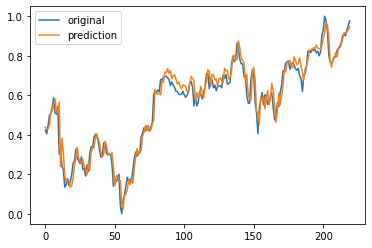

In [69]:
plt.plot(testY)
plt.plot(pred)
plt.legend(['original', 'prediction'])
plt.show()